# CC Fraud Analysis

_created by Austin Poor_

Analysis of credit card fraud data. Data source: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv("data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## EDA

Look at info about size of dataset and class balances

In [20]:
print(f"n observations => {df.shape[0]:,d}")
print(f"n features     => {df.shape[1]-1:7d}")

class_balance = df.Class.mean()
print(f"class balance  => {class_balance:7.5f}")

n observations => 284,807
n features     =>      30
class balance  => 0.00173


It looks like the classes are _super_ inbalanced

Plotting distributions for features

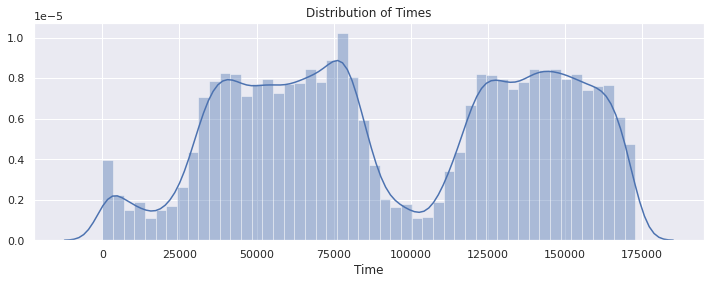

In [29]:
plt.figure(figsize=(12,4))
sns.distplot(df.Time)
plt.title("Distribution of Times");

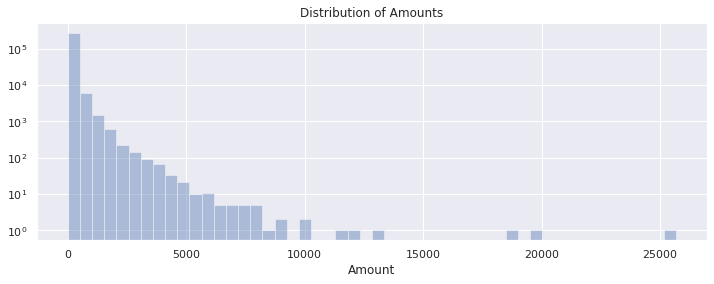

In [32]:
plt.figure(figsize=(12,4))
sns.distplot(df.Amount,kde=False)
plt.yscale('log')
plt.title("Distribution of Amounts");

Distributions for PCA transformed columns `V1`-`V28`

Distributions for Columns V1-V28


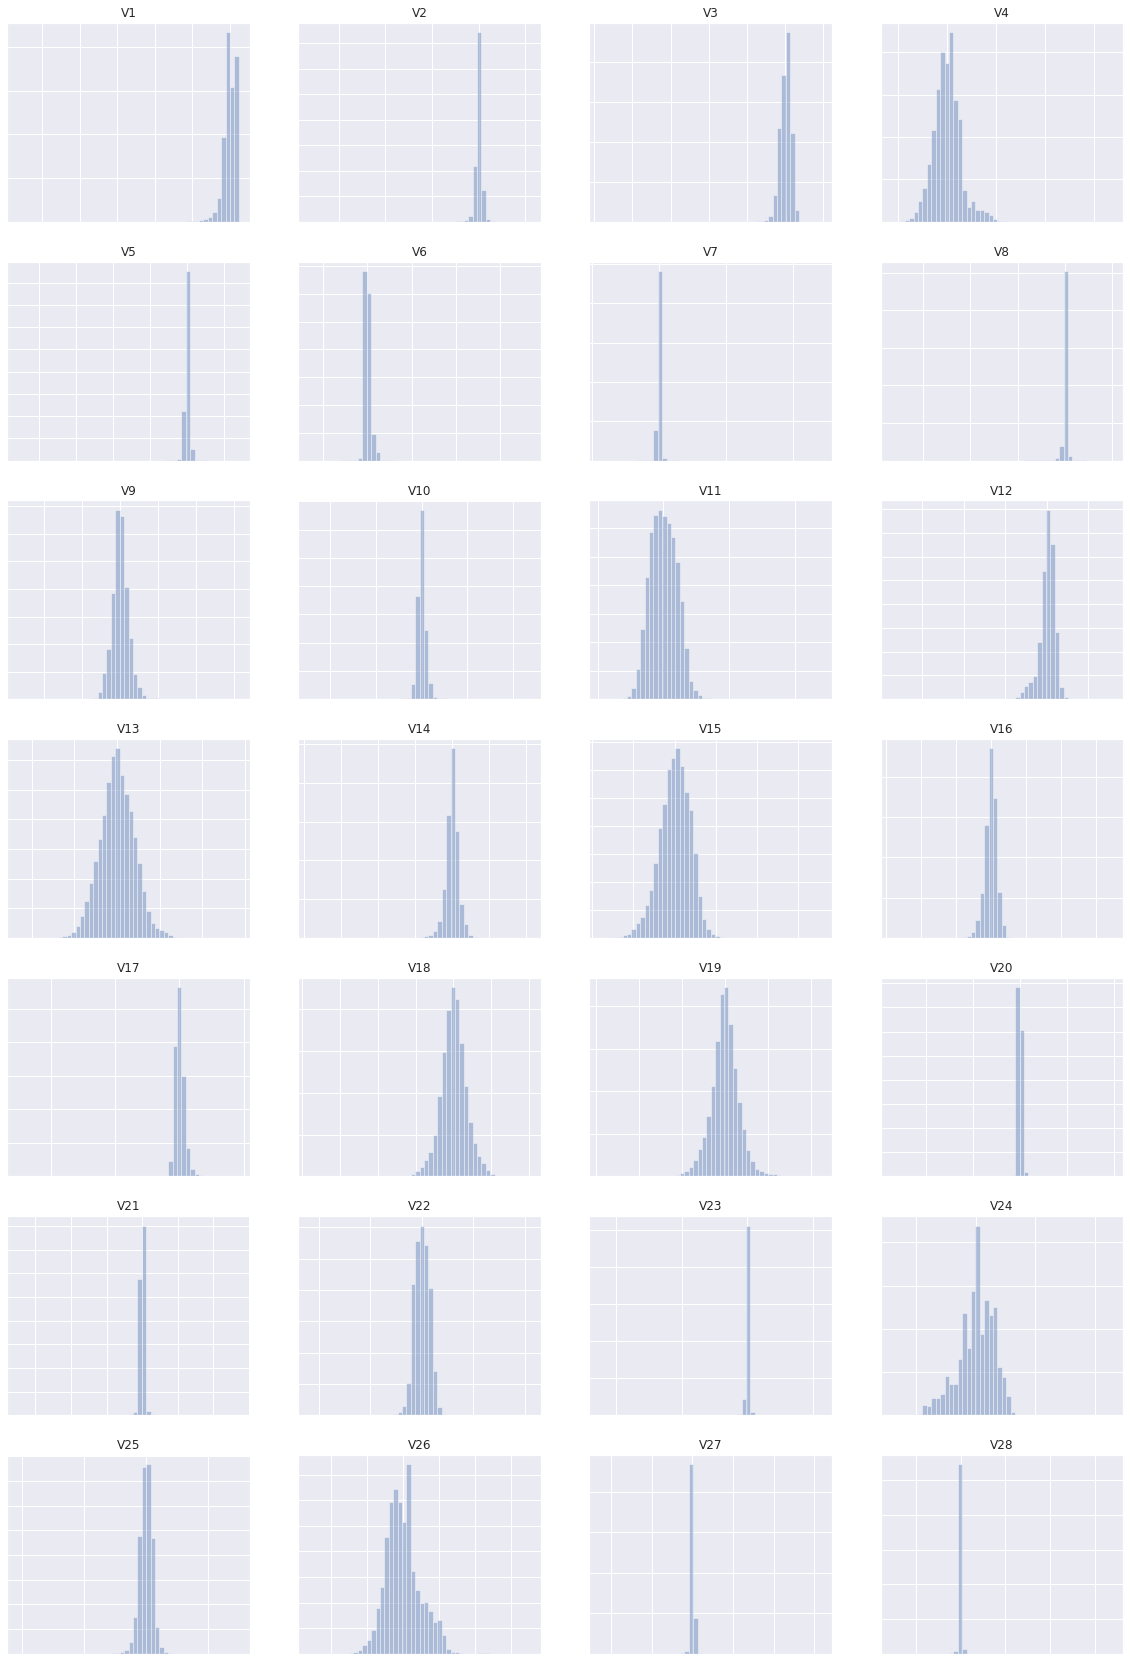

In [54]:
plt.figure(figsize=(20,30))
for i in range(1,29):
    plt.subplot(7,4,i)
    sns.distplot(df[f"V{i}"],kde=False)
    plt.title(f"V{i}")
    plt.xlabel("")
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

Examine the correlation between each feature and the target

In [64]:
df.corr()["Class"]\
    .reset_index()\
    .rename(columns={
        "index":"ColName",
        "Class":"Correlation"
    })\
    .sort_values(
        "Correlation",
        ascending=False,
        key=lambda n: abs(n)
    ).query("ColName != 'Class'")

,ColName,Correlation
17,V17,-0.326481
14,V14,-0.302544
12,V12,-0.260593
10,V10,-0.216883
16,V16,-0.196539
3,V3,-0.192961
7,V7,-0.187257
11,V11,0.154876
4,V4,0.133447
18,V18,-0.111485


---

## Building a model to make predictions

In [102]:
import pickle

In [77]:
from sklearn.model_selection import train_test_split

def train_test_val_split(X,y,test_pct=0.3,val_pct=0.33):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_pct)
    X_val, X_test, y_val, y_test = train_test_split(X_train,y_train,test_size=val_pct)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [146]:
from sklearn.metrics import confusion_matrix

def show_confusion(y_true,y_pred,log_transform=False):
    c = confusion_matrix(y_true,y_pred)
    if log_transform: 
        c = np.log(c + (1/len(y_true)))
    mat = pd.DataFrame(
        c,
        columns=["True -","True +"],
        index=["Pred -","Pred +"]
    )
    sns.heatmap(mat)
    plt.title("")

In [78]:
X = df.drop(columns="Class")
y = df["Class"]

(
    X_train, X_val, 
    X_test, y_train, 
    y_val, y_test
) = train_test_val_split(X,y)

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [125]:
log_pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("logreg",LogisticRegressionCV())
])
print(log_pipeline)
log_pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegressionCV())])


Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegressionCV())])

In [126]:
print(f"Prediction Score:  {log_pipeline.score(X_train,y_train):.6f}")
print(f"Prediction Score:  {log_pipeline.score(X_val,y_val):.6f}")
print(f"Prediction Score:  {log_pipeline.score(X_test,y_test):.6f}")
print(f"\nNaive Guess Score: {1-class_balance:.6f}")

Prediction Score:  0.999147
Prediction Score:  0.999199
Prediction Score:  0.999042

Naive Guess Score: 0.998273


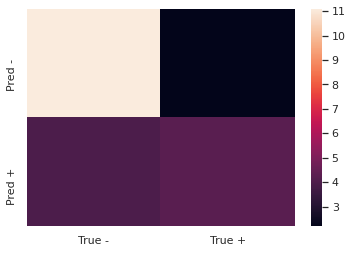

In [147]:
show_confusion(
    y_test,
    log_pipeline.predict(X_test),
    True
)

In [ ]:
with open("models/")

## Gradient Boosted Treeslog_pipeline

### XGBoost

In [91]:
from xgboost import XGBClassifier

In [112]:
xgbc = XGBClassifier()
xgbc.fit(
    X_train,
    y_train,
    eval_set=[
        (X_val,y_val)
    ],
    verbose=False
)

print(f"Train Score: {xgbc.score(X_train,y_train):.6f}")
print(f"Val   Score: {xgbc.score(X_val,y_val):.6f}")

xgbc_test_score = xgbc.score(X_test,y_test)
print(f"Test  Score: {xgbc_test_score:.6f}")

[0]	validation_0-error:0.00043
[1]	validation_0-error:0.00038
[2]	validation_0-error:0.00034
[3]	validation_0-error:0.00033
[4]	validation_0-error:0.00030
[5]	validation_0-error:0.00029
[6]	validation_0-error:0.00028
[7]	validation_0-error:0.00027
[8]	validation_0-error:0.00027
[9]	validation_0-error:0.00027
[10]	validation_0-error:0.00027
[11]	validation_0-error:0.00027
[12]	validation_0-error:0.00026
[13]	validation_0-error:0.00026
[14]	validation_0-error:0.00026
[15]	validation_0-error:0.00026
[16]	validation_0-error:0.00026
[17]	validation_0-error:0.00025
[18]	validation_0-error:0.00023
[19]	validation_0-error:0.00023
[20]	validation_0-error:0.00023
[21]	validation_0-error:0.00022
[22]	validation_0-error:0.00022
[23]	validation_0-error:0.00020
[24]	validation_0-error:0.00019
[25]	validation_0-error:0.00019
[26]	validation_0-error:0.00018
[27]	validation_0-error:0.00018
[28]	validation_0-error:0.00016
[29]	validation_0-error:0.00014
[30]	validation_0-error:0.00015
[31]	validation_0-

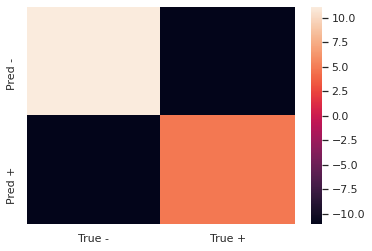

In [148]:
show_confusion(
    y_test,
    xgbc.predict(X_test),
    True
)

In [117]:
with open(f"models/xgbc_{xgbc_test_score}_test.pkl","wb") as f:
    pickle.dump(xgbc,f)

### LightGBM

In [101]:
from lightgbm import LGBMClassifier

In [113]:
lgbc = LGBMClassifier(
    class_weight={
        0: 1-class_balance,
        1: class_balance
    }
)
lgbc.fit(
    X_train,
    y_train,
    eval_set=[
        (X_val,y_val)
    ],
    verbose=True
)
lgbc.score(X_test,y_test)

print(f"Train Score: {lgbc.score(X_train,y_train):.6f}")
print(f"Val   Score: {lgbc.score(X_val,y_val):.6f}")

lgbc_test_score = lgbc.score(X_test,y_test)
print(f"Test  Score: {lgbc_test_score:.6f}")

[1]	valid_0's binary_logloss: 0.0502686
[2]	valid_0's binary_logloss: 0.0482889
[3]	valid_0's binary_logloss: 0.071049
[4]	valid_0's binary_logloss: 0.0485726
[5]	valid_0's binary_logloss: 0.0577783
[6]	valid_0's binary_logloss: 0.0491893
[7]	valid_0's binary_logloss: 0.0715407
[8]	valid_0's binary_logloss: 0.0490397
[9]	valid_0's binary_logloss: 0.0627094
[10]	valid_0's binary_logloss: 0.0493018
[11]	valid_0's binary_logloss: 0.0491222
[12]	valid_0's binary_logloss: 0.0530798
[13]	valid_0's binary_logloss: 0.0513108
[14]	valid_0's binary_logloss: 0.0508115
[15]	valid_0's binary_logloss: 0.0504645
[16]	valid_0's binary_logloss: 0.050249
[17]	valid_0's binary_logloss: 0.0500847
[18]	valid_0's binary_logloss: 0.0498973
[19]	valid_0's binary_logloss: 0.049765
[20]	valid_0's binary_logloss: 0.0497416
[21]	valid_0's binary_logloss: 0.0499177
[22]	valid_0's binary_logloss: 0.049681
[23]	valid_0's binary_logloss: 0.049574
[24]	valid_0's binary_logloss: 0.0494839
[25]	valid_0's binary_logloss:

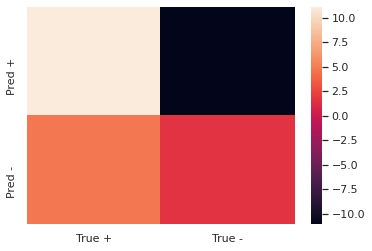

In [139]:
show_confusion(
    y_test,
    lgbc.predict(X_test),
    True
)

In [116]:
with open(f"models/xgbc_{lgbc_test_score}_test.pkl","wb") as f:
    pickle.dump(lgbc,f)

In [145]:
confusion_matrix(y,np.zeros(len(y)))

array([[284315,      0],
       [   492,      0]])